In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11

In [2]:
# Load data
conn = sqlite3.connect('../output/literary_works.db')

query = """
SELECT 
    lw.item_id,
    lw.itemLabel,
    lw.instanceLabel,
    lw.countryLabel,
    lw.languageLabel,
    lw.authorLabel,
    lw.year,
    c.main_region as region
FROM literary_works lw
LEFT JOIN countries c ON lw.modern_country = c.modern_country
LEFT JOIN instances i ON lw.instanceLabel = i.label
WHERE lw.year IS NOT NULL 
  AND lw.year < 1900
  AND (i.excluded = 0 OR i.excluded IS NULL)
"""

df = pd.read_sql(query, conn)
conn.close()

df = df.dropna(subset=['region'])

print(f"Total works before 1900 with year and region: {len(df):,}")
print(f"Date range: {df['year'].min()} - {df['year'].max()}")
print(f"Unique regions: {df['region'].nunique()}")
print(f"Unique instance types: {df['instanceLabel'].nunique()}")

Total works before 1900 with year and region: 1,732,924
Date range: -2999 - 1899
Unique regions: 13
Unique instance types: 734


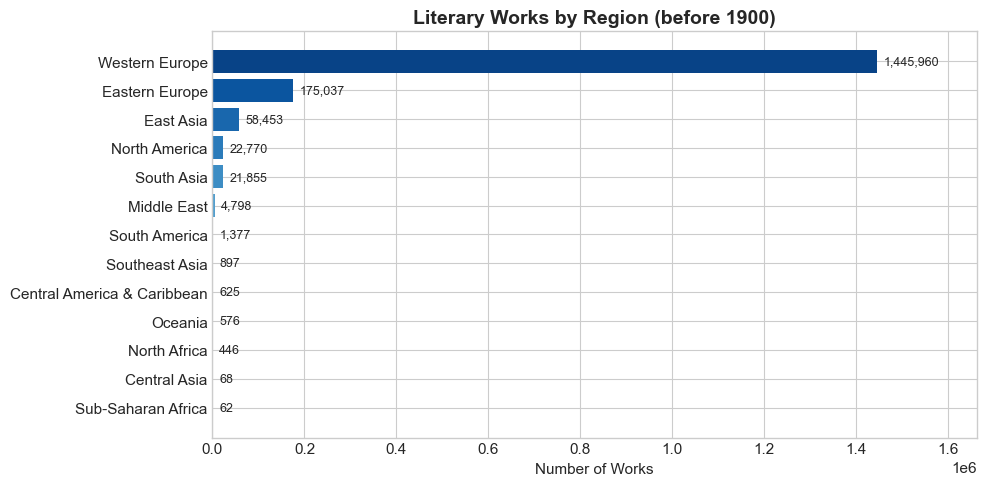

In [3]:
# Overview: Works by region
region_counts = df['region'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('Blues_r', len(region_counts))
bars = ax.barh(region_counts.index[::-1], region_counts.values[::-1], color=colors[::-1])
ax.set_xlabel('Number of Works')
ax.set_title('Literary Works by Region (before 1900)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, region_counts.values[::-1]):
    ax.text(val + region_counts.max()*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:,}', va='center', fontsize=9)
ax.set_xlim(0, region_counts.max() * 1.15)
plt.tight_layout()
plt.show()

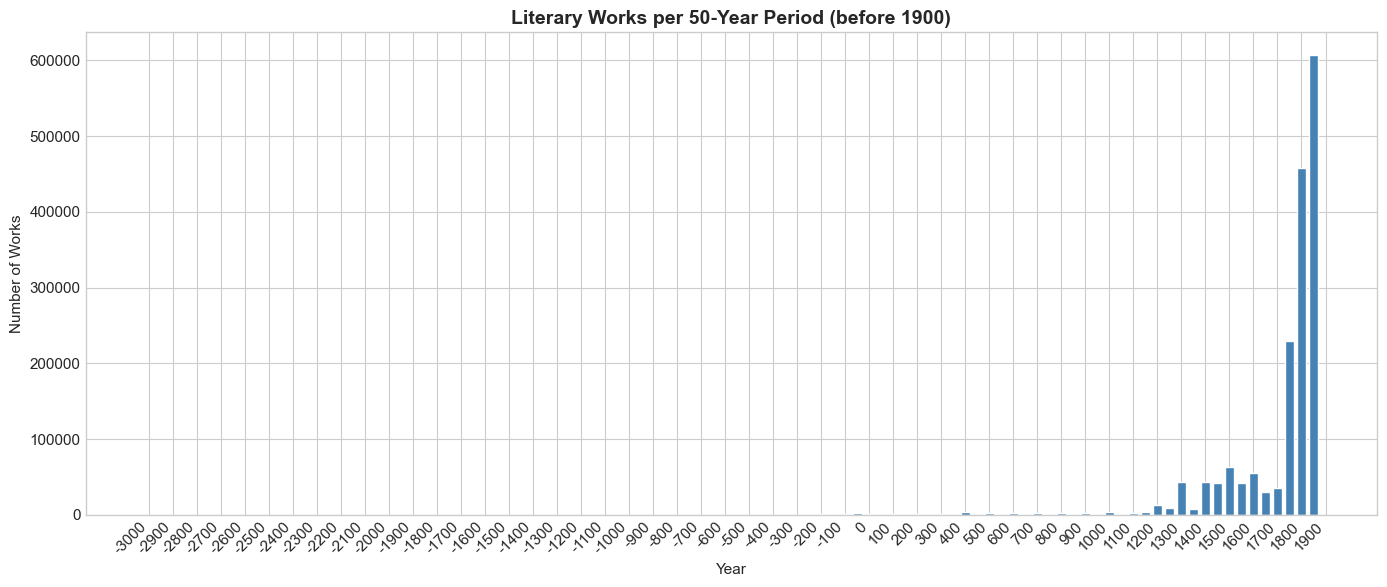

In [4]:
# Timeline: Overall works count per 50 years
df['fifty_year'] = (df['year'] // 50) * 50

counts_50y = df.groupby('fifty_year').size()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(counts_50y.index, counts_50y.values, width=40, color='steelblue', edgecolor='white')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Works')
ax.set_title('Literary Works per 50-Year Period (before 1900)', fontsize=14, fontweight='bold')

# Set x-axis ticks every 100 years
min_year = (counts_50y.index.min() // 100) * 100
max_year = (counts_50y.index.max() // 100 + 1) * 100
ax.set_xticks(range(min_year, max_year + 1, 100))
ax.set_xticklabels([str(y) for y in range(min_year, max_year + 1, 100)], rotation=45, ha='right')

plt.tight_layout()
plt.show()

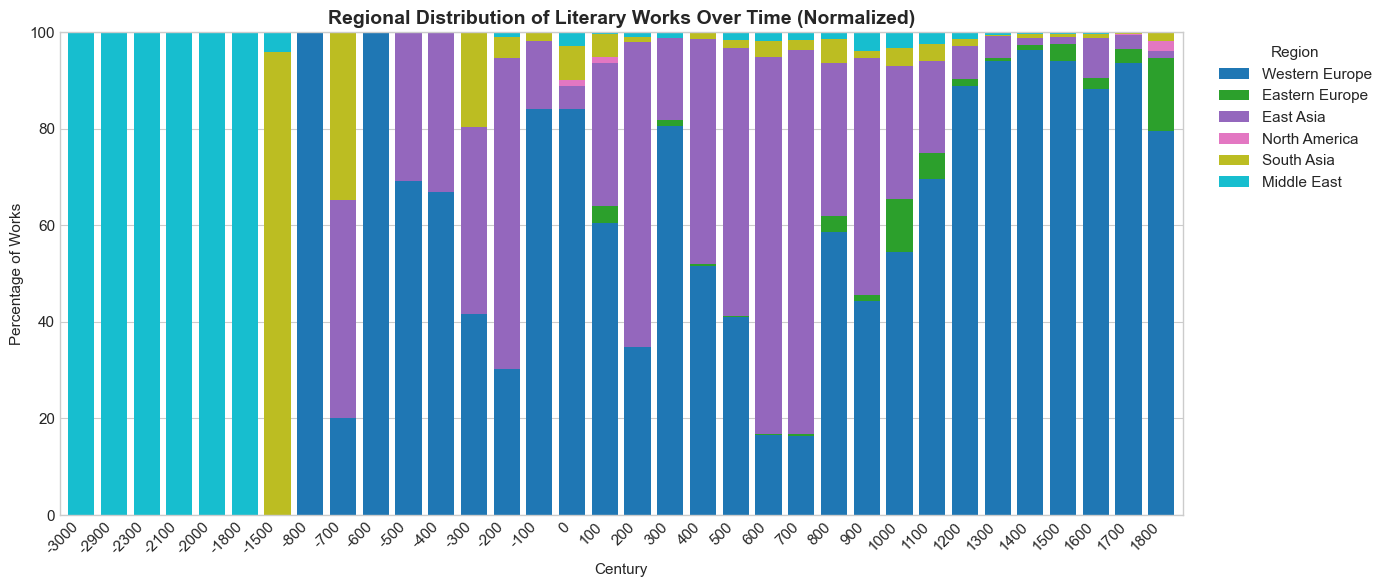

In [5]:
# Normalized stacked bar chart: Distribution per region over time
df['century'] = (df['year'] // 100) * 100
top_regions = df['region'].value_counts().head(6).index.tolist()

timeline = df[df['region'].isin(top_regions)].groupby(['century', 'region']).size().unstack(fill_value=0)
timeline = timeline[top_regions]

# Normalize by century (each century = 100%)
timeline_norm = timeline.div(timeline.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 6))
timeline_norm.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)
ax.set_xlabel('Century')
ax.set_ylabel('Percentage of Works')
ax.set_title('Regional Distribution of Literary Works Over Time (Normalized)', fontsize=14, fontweight='bold')
ax.legend(title='Region', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels([f'{int(x)}' for x in timeline_norm.index], rotation=45, ha='right')
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

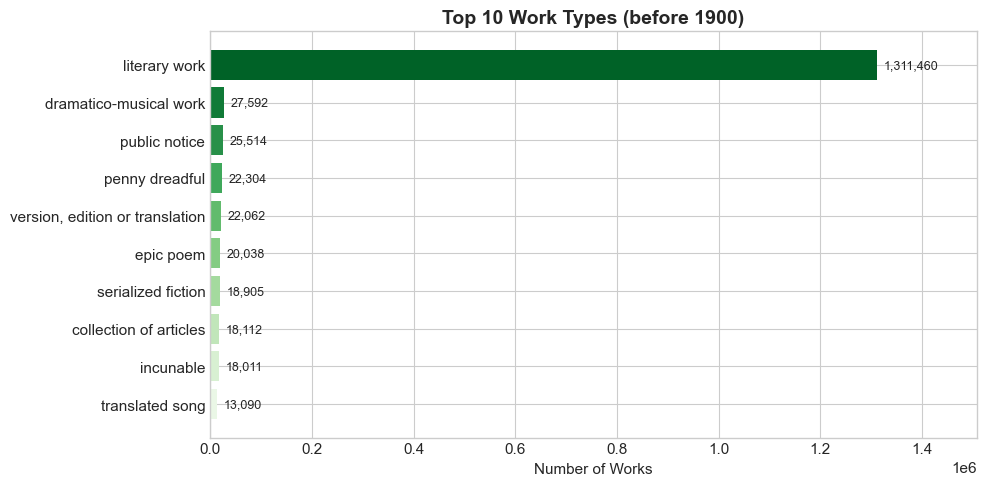

In [6]:
# Instance types: Top 10 overall
instance_counts = df['instanceLabel'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('Greens_r', len(instance_counts))
bars = ax.barh(instance_counts.index[::-1], instance_counts.values[::-1], color=colors[::-1])
ax.set_xlabel('Number of Works')
ax.set_title('Top 10 Work Types (before 1900)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, instance_counts.values[::-1]):
    ax.text(val + instance_counts.max()*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:,}', va='center', fontsize=9)
ax.set_xlim(0, instance_counts.max() * 1.15)
plt.tight_layout()
plt.show()

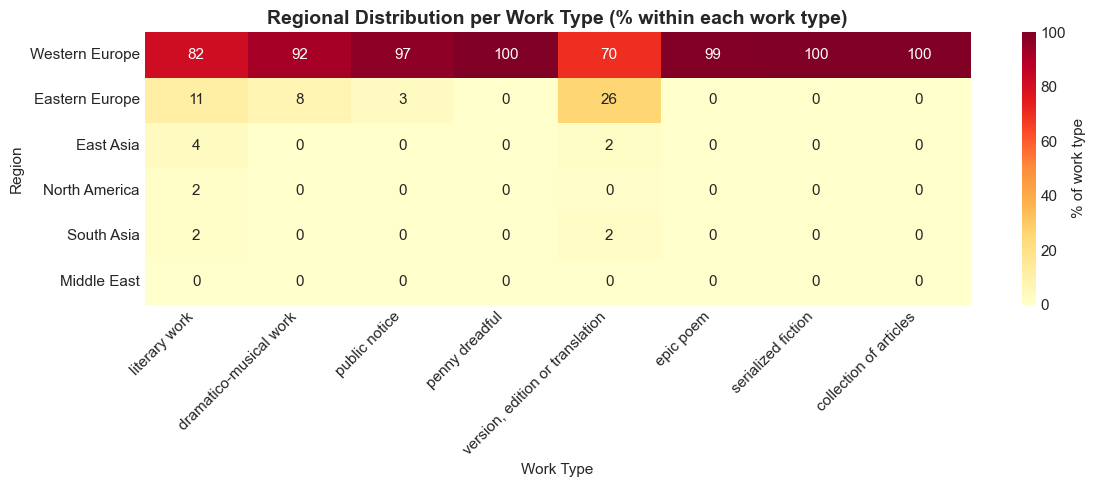

In [7]:
# Heatmap: Regional distribution per work type (normalized by work type)
top_instances = df['instanceLabel'].value_counts().head(8).index.tolist()
top_6_regions = df['region'].value_counts().head(6).index.tolist()

heatmap_data = df[df['instanceLabel'].isin(top_instances) & df['region'].isin(top_6_regions)]
pivot = heatmap_data.groupby(['region', 'instanceLabel']).size().unstack(fill_value=0)
pivot = pivot[top_instances]  # reorder columns
pivot = pivot.loc[top_6_regions]  # reorder rows

# Normalize by column (each work type = 100%)
pivot_norm = pivot.div(pivot.sum(axis=0), axis=1) * 100

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot_norm, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax, 
            cbar_kws={'label': '% of work type'})
ax.set_title('Regional Distribution per Work Type (% within each work type)', fontsize=14, fontweight='bold')
ax.set_xlabel('Work Type')
ax.set_ylabel('Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Part 2: Analysis Excluding Western Europe

The following analysis focuses on all regions except Western Europe to better understand patterns in other parts of the world.

In [8]:
# Filter out Western Europe
df_no_west = df[df['region'] != 'Western Europe'].copy()

print(f"Total works (excluding Western Europe): {len(df_no_west):,}")
print(f"Date range: {df_no_west['year'].min()} - {df_no_west['year'].max()}")
print(f"Unique regions: {df_no_west['region'].nunique()}")
print(f"Unique instance types: {df_no_west['instanceLabel'].nunique()}")

Total works (excluding Western Europe): 286,964
Date range: -2999 - 1899
Unique regions: 12
Unique instance types: 377


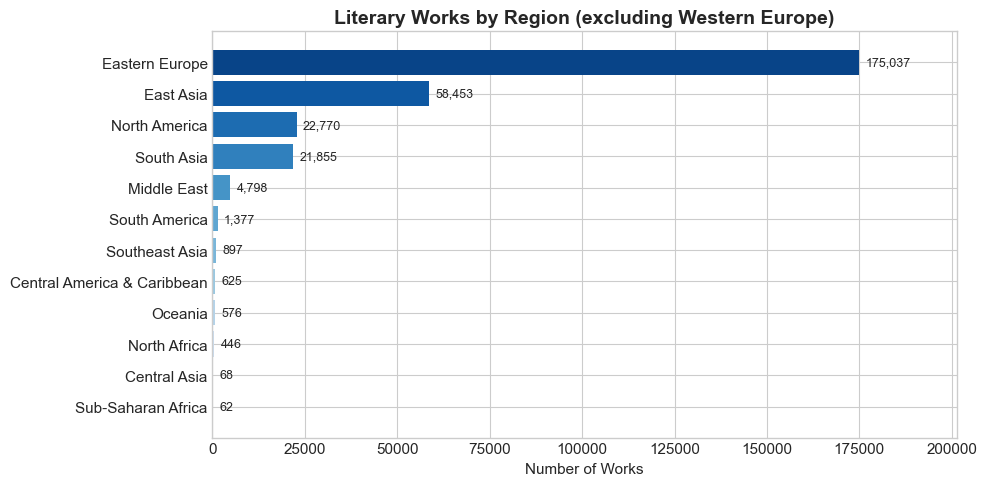

In [9]:
# Works by region (excluding Western Europe)
region_counts_no_west = df_no_west['region'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('Blues_r', len(region_counts_no_west))
bars = ax.barh(region_counts_no_west.index[::-1], region_counts_no_west.values[::-1], color=colors[::-1])
ax.set_xlabel('Number of Works')
ax.set_title('Literary Works by Region (excluding Western Europe)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, region_counts_no_west.values[::-1]):
    ax.text(val + region_counts_no_west.max()*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:,}', va='center', fontsize=9)
ax.set_xlim(0, region_counts_no_west.max() * 1.15)
plt.tight_layout()
plt.show()

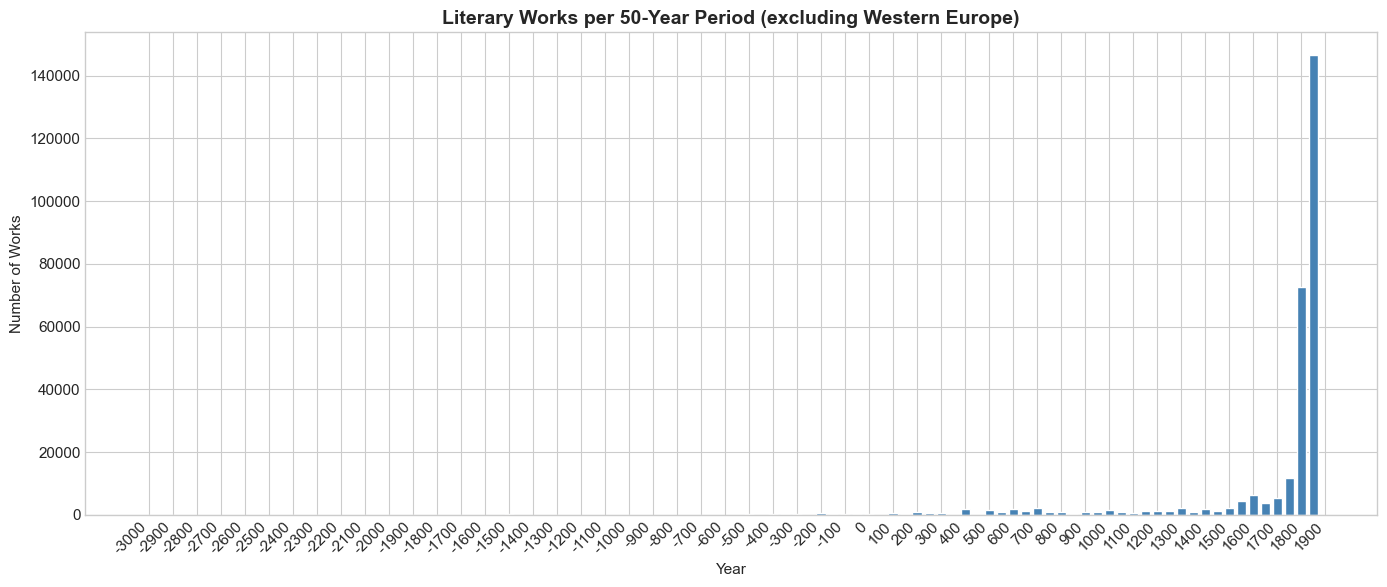

In [10]:
# Timeline: Works per 50 years (excluding Western Europe)
df_no_west['fifty_year'] = (df_no_west['year'] // 50) * 50
counts_50y_no_west = df_no_west.groupby('fifty_year').size()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(counts_50y_no_west.index, counts_50y_no_west.values, width=40, color='steelblue', edgecolor='white')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Works')
ax.set_title('Literary Works per 50-Year Period (excluding Western Europe)', fontsize=14, fontweight='bold')

min_year = (counts_50y_no_west.index.min() // 100) * 100
max_year = (counts_50y_no_west.index.max() // 100 + 1) * 100
ax.set_xticks(range(min_year, max_year + 1, 100))
ax.set_xticklabels([str(y) for y in range(min_year, max_year + 1, 100)], rotation=45, ha='right')

plt.tight_layout()
plt.show()

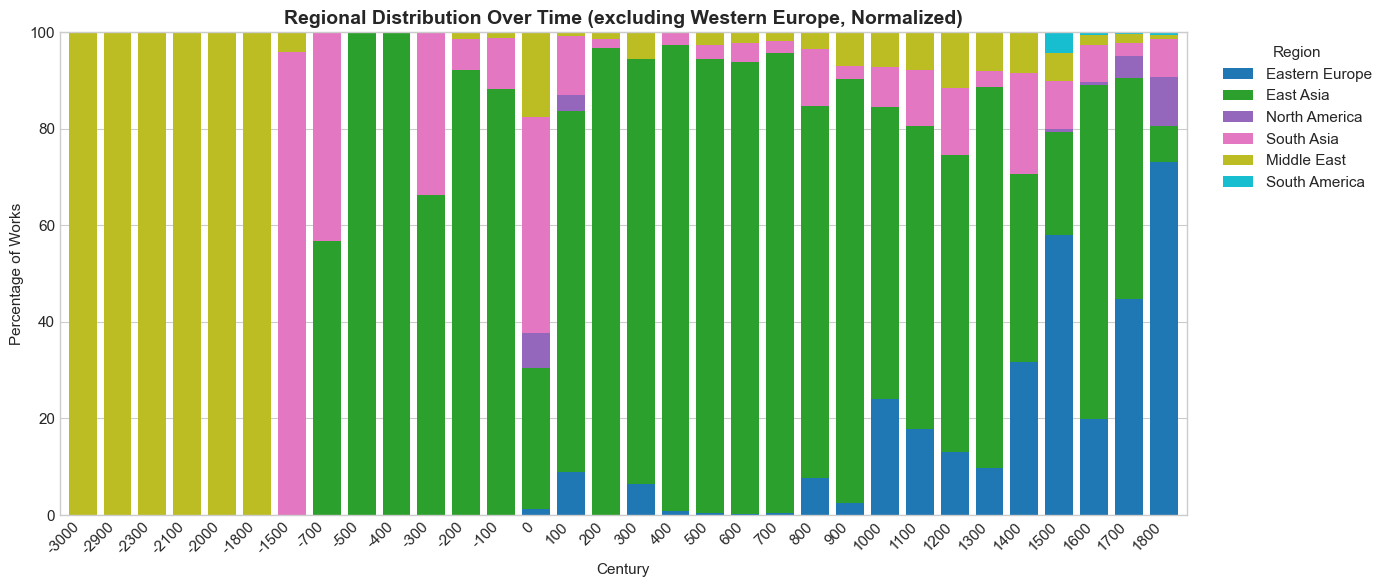

In [11]:
# Normalized stacked bar chart: Distribution per region over time (excluding Western Europe)
df_no_west['century'] = (df_no_west['year'] // 100) * 100
top_regions_no_west = df_no_west['region'].value_counts().head(6).index.tolist()

timeline_no_west = df_no_west[df_no_west['region'].isin(top_regions_no_west)].groupby(['century', 'region']).size().unstack(fill_value=0)
timeline_no_west = timeline_no_west[top_regions_no_west]

# Normalize by century (each century = 100%)
timeline_norm_no_west = timeline_no_west.div(timeline_no_west.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 6))
timeline_norm_no_west.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)
ax.set_xlabel('Century')
ax.set_ylabel('Percentage of Works')
ax.set_title('Regional Distribution Over Time (excluding Western Europe, Normalized)', fontsize=14, fontweight='bold')
ax.legend(title='Region', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels([f'{int(x)}' for x in timeline_norm_no_west.index], rotation=45, ha='right')
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

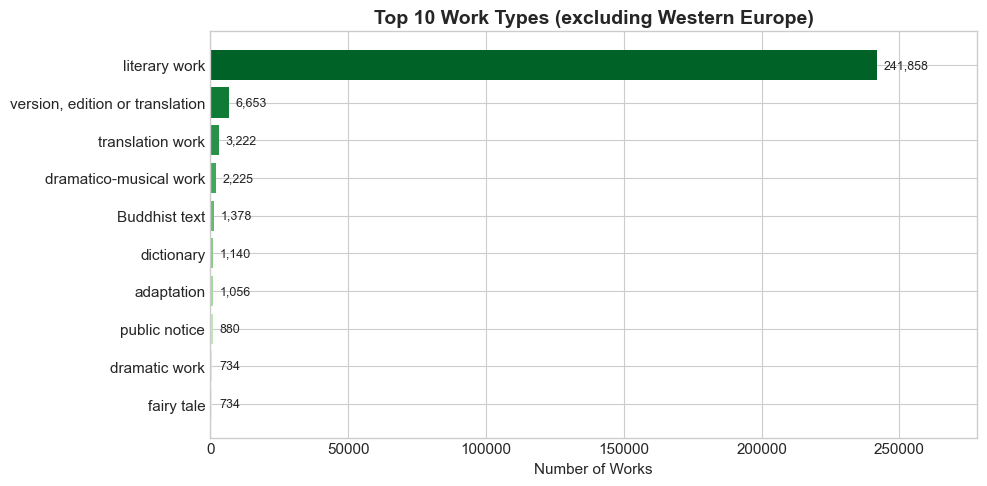

In [12]:
# Instance types: Top 10 (excluding Western Europe)
instance_counts_no_west = df_no_west['instanceLabel'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('Greens_r', len(instance_counts_no_west))
bars = ax.barh(instance_counts_no_west.index[::-1], instance_counts_no_west.values[::-1], color=colors[::-1])
ax.set_xlabel('Number of Works')
ax.set_title('Top 10 Work Types (excluding Western Europe)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, instance_counts_no_west.values[::-1]):
    ax.text(val + instance_counts_no_west.max()*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:,}', va='center', fontsize=9)
ax.set_xlim(0, instance_counts_no_west.max() * 1.15)
plt.tight_layout()
plt.show()

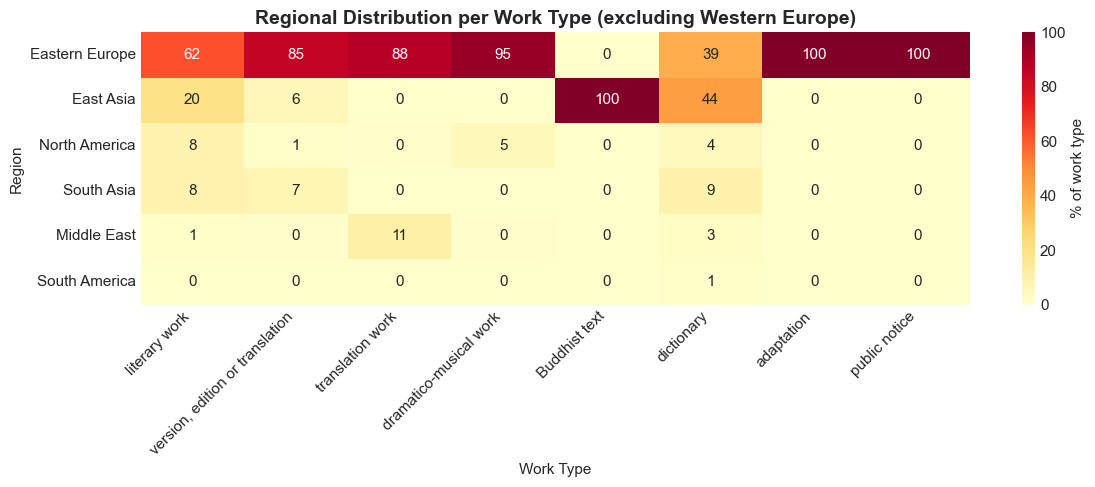

In [13]:
# Heatmap: Regional distribution per work type (excluding Western Europe)
top_instances_no_west = df_no_west['instanceLabel'].value_counts().head(8).index.tolist()
top_6_regions_no_west = df_no_west['region'].value_counts().head(6).index.tolist()

heatmap_data_no_west = df_no_west[df_no_west['instanceLabel'].isin(top_instances_no_west) & df_no_west['region'].isin(top_6_regions_no_west)]
pivot_no_west = heatmap_data_no_west.groupby(['region', 'instanceLabel']).size().unstack(fill_value=0)
pivot_no_west = pivot_no_west[top_instances_no_west]
pivot_no_west = pivot_no_west.loc[top_6_regions_no_west]

# Normalize by column (each work type = 100%)
pivot_norm_no_west = pivot_no_west.div(pivot_no_west.sum(axis=0), axis=1) * 100

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(pivot_norm_no_west, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax, 
            cbar_kws={'label': '% of work type'})
ax.set_title('Regional Distribution per Work Type (excluding Western Europe)', fontsize=14, fontweight='bold')
ax.set_xlabel('Work Type')
ax.set_ylabel('Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
# Top 5 formats (work types) per big region
top_5_formats_per_region = (
    df.groupby(['region', 'instanceLabel'])
    .size()
    .reset_index(name='count')
    .sort_values(['region', 'count'], ascending=[True, False])
    .groupby('region')
    .head(5)
)

# Display as a formatted table
for region in sorted(df['region'].unique()):
    region_data = top_5_formats_per_region[top_5_formats_per_region['region'] == region]
    print(f"\n{'='*50}")
    print(f"  {region}")
    print(f"{'='*50}")
    for i, (_, row) in enumerate(region_data.iterrows(), 1):
        print(f"  {i}. {row['instanceLabel']}: {row['count']:,}")


  Central America & Caribbean
  1. literary work: 546
  2. dramatico-musical work: 15
  3. manuscript: 10
  4. written work: 10
  5. bilingual dictionary: 5

  Central Asia
  1. literary work: 56
  2. historical non-fiction work: 5
  3. written work: 5
  4. epic poem: 2

  East Asia
  1. literary work: 47,038
  2. Buddhist text: 1,377
  3. history book: 643
  4. dictionary: 504
  5. rhyme dictionary: 487

  Eastern Europe
  1. literary work: 149,050
  2. version, edition or translation: 5,635
  3. translation work: 2,847
  4. dramatico-musical work: 2,092
  5. adaptation: 1,056

  Middle East
  1. literary work: 3,166
  2. translation work: 351
  3. religious text: 151
  4. periodical: 140
  5. yearbook: 140

  North Africa
  1. literary work: 294
  2. New Testament apocrypha: 42
  3. manuscript: 24
  4. apocryphal gospel: 12
  5. literary fragment: 12

  North America
  1. literary work: 19,720
  2. medical journal: 390
  3. religious text: 225
  4. society journal: 180
  5. periodic